In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=28087fde2ae39fe4c99d3a044b2d4851116b4621a500e6dd2eb7e84cc5ea00ea
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tarfile
import wget
import os
import re
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Data


In [4]:
print('Downloading dataset...')
url = 'http://www.statmt.org/europarl/v7/fr-en.tgz'

if not os.path.exists('./fr-en.tgz'):
    wget.download(url, './fr-en.tgz')

if not (os.path.exists('./europarl-v7.fr-en.fr') and os.path.exists('./europarl-v7.fr-en.en')):
    taf = tarfile.open("./fr-en.tgz")
    taf.extractall()

In [5]:
os.listdir()

['.config',
 'europarl-v7.fr-en.en',
 'fr-en.tgz',
 'europarl-v7.fr-en.fr',
 'sample_data']

# Prepare Data

In [0]:
def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text

In [0]:
def to_sentences(doc):
    return doc.strip().lower().split('\n')

In [0]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)    # pad punctuations with space on both sides 
    w = re.sub(r'[" "]+', " ", w)       # replace multiple spaces with a single space
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)      # replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = w.strip()
    #w = '<start> ' + w + ' <end>'
    return w

In [0]:
def add_start_token(w):
    w  = '<start>' + w
    return w

In [0]:
def add_end_token(w):
    w = w + ' <end>'
    return w

In [0]:
def create_dataset(num_samples):
    en = to_sentences(load_doc('./europarl-v7.fr-en.en'))
    fr = to_sentences(load_doc('./europarl-v7.fr-en.fr'))

    e_sents_op = [add_end_token(preprocess_sentence(w)) for w in en]
    e_sents_ip = [add_start_token(w) for w in e_sents_op]
    f_sents = [add_start_token(add_end_token(preprocess_sentence(w))) for w in fr]


    return e_sents_ip[:num_samples], e_sents_op[:num_samples], f_sents[:num_samples]

In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>")
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [0]:
def load_dataset(num_samples):

    en_ip, en_op, fr = create_dataset(num_samples)

    en_tensor_ip, en_tokenizer = tokenize(en_ip)

    en_tensor_op = en_tokenizer.texts_to_sequences(en_op)
    en_tensor_op = tf.keras.preprocessing.sequence.pad_sequences(en_tensor_op, padding='post')

    fr_tensor, fr_tokenizer = tokenize(fr)

    return fr_tensor, en_tensor_ip, en_tensor_op, fr_tokenizer, en_tokenizer

In [0]:
enc_input, dec_input, dec_target, inp_lang, targ_lang = load_dataset(1000)

In [15]:
enc_inp_train, enc_inp_test, dec_inp_train, _, dec_op_train, dec_op_test = train_test_split(enc_input, dec_input, dec_target, test_size=0.2)
print(len(enc_inp_train), len(enc_inp_test), len(dec_inp_train), len(dec_op_train), len(dec_op_test))

800 200 800 800 200


In [0]:
BUFFER_SIZE = len(enc_inp_train)
BATCH_SIZE = 128
steps_per_epoch = len(enc_inp_train)//BATCH_SIZE
embedding_dim = 1000
units = 1000
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((enc_inp_train, dec_inp_train, dec_op_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [19]:
inp_max_len, tar_max_len = max_length(enc_inp_train), max_length(dec_inp_train)
print(inp_max_len, tar_max_len)

167 132


# Model

In [0]:
# encoder

enc_inp = tf.keras.Input((inp_max_len, vocab_inp_size))
#inp_emb = tf.keras.layers.Embedding(vocab_inp_size, embedding_dim, mask_zero=True)(enc_inp)

enc_lstm_1 = tf.keras.layers.LSTM(units, return_sequences=True)(enc_inp)#_emb)
enc_lstm_2 = tf.keras.layers.LSTM(units, return_sequences=True)(enc_lstm_1)
enc_lstm_3 = tf.keras.layers.LSTM(units, return_sequences=True)(enc_lstm_2)

enc_op, state_h, state_c = tf.keras.layers.LSTM(units, return_state=True)(enc_lstm_3)
encoder_states = [state_h, state_c]

In [0]:
# decoder

dec_lstm = tf.keras.layers.LSTM(units, activation='softmax', return_sequences=True, return_state=True)
dec_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_tar_size, activation='softmax'))

dec_inp = tf.keras.Input((tar_max_len, vocab_tar_size))
#tar_emb = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim, mask_zero=True)(dec_inp)
dec_op, _, _ = dec_lstm(dec_inp, initial_state=encoder_states)
outputs = dec_dense(dec_op)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 167, 3897)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 167, 1000)    19592000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 167, 1000)    8004000     lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 167, 1000)    8004000     lstm_1[0][0]                     
______________________________________________________________________________________________

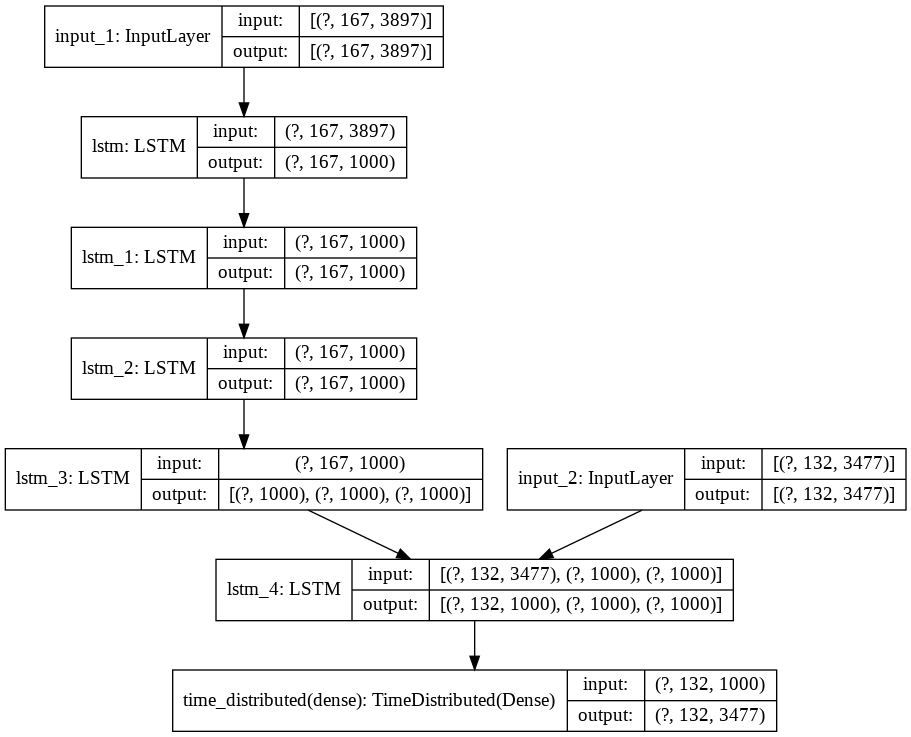

In [22]:
seq2seq = tf.keras.Model([enc_inp, dec_inp], outputs)
seq2seq.summary()
tf.keras.utils.plot_model(seq2seq, to_file='seq2seq_plot.png', show_shapes=True, show_layer_names=True)

# Train

In [0]:
opt = tf.keras.optimizers.Adam()
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_ reduction='none')

seq2seq.compile(optimizer=opt, loss='categorical_crossentropy')

In [0]:
EPOCHS = 1

In [32]:
for epoch in range(EPOCHS):
    print('Epoch : %d / %d '% ((epoch+1), EPOCHS))
    for batch, (enc_ip, dec_ip, dec_op) in enumerate(dataset.take(steps_per_epoch)):
        print('Step : %d / %d' % ((batch+1), steps_per_epoch))
        enc_ip = tf.one_hot(enc_ip, depth = vocab_inp_size)
        dec_ip = tf.one_hot(dec_ip, depth = vocab_tar_size)
        dec_op = tf.one_hot(dec_op, depth=vocab_tar_size)
        print(enc_ip.shape)
        print(dec_ip.shape)
        print(dec_op.shape)
        op = seq2seq.predict([enc_ip, dec_ip])
        print(op.shape)
        seq2seq.train_on_batch([enc_ip, dec_ip], dec_op)

Epoch : 1 / 1 
Step : 1 / 6
(128, 167, 3897)
(128, 132, 3477)
(128, 132, 3477)
(128, 132, 3477)
Step : 2 / 6
(128, 167, 3897)
(128, 132, 3477)
(128, 132, 3477)
(128, 132, 3477)
Step : 3 / 6
(128, 167, 3897)
(128, 132, 3477)
(128, 132, 3477)
(128, 132, 3477)
Step : 4 / 6
(128, 167, 3897)
(128, 132, 3477)
(128, 132, 3477)
(128, 132, 3477)
Step : 5 / 6
(128, 167, 3897)
(128, 132, 3477)
(128, 132, 3477)
(128, 132, 3477)
Step : 6 / 6
(128, 167, 3897)
(128, 132, 3477)
(128, 132, 3477)
(128, 132, 3477)


# Inference

In [0]:
encoder_model = tf.keras.Model(enc_inp, encoder_states)

state_inp_h = tf.keras.Input((units))
state_inp_c = tf.keras.Input((units))
dec_state_inps = [state_inp_h, state_inp_c]
decoder_op, state_h, state_c = dec_lstm(dec_inp, initial_state = dec_state_inps) 
decoder_op = dec_dense(decoder_op)
decoder_states = [state_h, state_c]

decoder_model = Model([dec_inp]+dec_state_inps, [decoder_op]+decoder_states)

In [0]:
def inference_preprocess(input_seq):
    input_seq = add_end_token(add_start_token(preprocess_sentence))
    input_seq = inp_lang.texts_to_sequences(input_seq)
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, inp_max_len, padding='post')
    input_seq = tf.one_hot(input_seq, depth=vocab_inp_size)

    return input seq

In [0]:
def decode_sequence(input_seq):

    input_seq = inference_preprocess(input_seq)
    states = encoder_model.predict(input_seq)
    
    target_seq = tf.ones((1,1,vocab_tar_size))
    target_seq[0, 0, targ_lang.word_index['<start>']] = 1

    stop = False
    decoded_sent = " "
    while not stop:
        output_tokens = decoder_model([target_seq]+states)

